In [6]:
import nltk
import re
import string

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

In [20]:
data = pd.read_csv('SMSSpamCollection.csv',sep="\t", names=['tag','text'],header=None)

In [8]:
#preprocessing

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer() 

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split(r'\s+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [21]:
data['text'] = data['text'].apply(lambda x: clean_text(x))
data.replace('ham', 0, inplace=True)
data.replace('spam', 1,inplace=True)
data.head(3)

,tag,text
0,0,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,"[ok, lar, joke, wif, u, oni]"
2,1,"[free, entri, 2, wkli, comp, win, fa, cup, fin..."


In [22]:
X=np.array(data['text'])
y=np.array(data['tag'])

In [23]:
def VocabList_count(data_x,data_y):
    #creat vacabulary lists( get all the words in the dataset)
    spam_list = []
    ham_list = []
    #creat dictionary for 1 and 0 group
    spam_dict = {}
    ham_dict = {}
    
    for i in range(len(data_y)):
        if data_y[i] == 1:
            spam_list.append(data_x[i])
            for word in data_x[i]:
                if word in spam_dict:
                    spam_dict[word] += 1
                else:
                    spam_dict[word] = 1
        
        elif data_y[i] == 0:
            ham_list.append(data_x[i])
            for word in data_x[i]:
                if word in ham_dict:
                    ham_dict[word] += 1
                else:
                    ham_dict[word] = 1

    return spam_list,ham_list,spam_dict,ham_dict

In [24]:
from sklearn.model_selection import StratifiedKFold
accuracy = []
kfold = StratifiedKFold(n_splits=5)
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    vocab1,vocab0,dict1,dict0 = VocabList_count(X_train,y_train)

# calculate probabilities    
    total_num = len(X_train) #total number of words
    percent_1 = len(vocab1) / total_num
    percent_0 = len(vocab0) / total_num
    total_1 = sum(list(dict1.values()))
    total_0 = sum(list(dict0.values()))

# make predictions    
    y_pred = []
    for i in range(len(X_test)):
        prob_1 = 1  #initialize
        prob_0 = 1
        
        for words in X_test[i]:
            if words in dict1:
                word_in_spam = dict1[words]
            elif words not in dict1:
                word_in_spam = 0
        prob_1 *= (word_in_spam + 1) / (total_1 + len(dict1)) #  +1 smoothing
        
        for words in X_test[i]:
            if words in dict0:
                word_in_ham = dict0[words]
            elif words not in dict0:
                word_in_ham = 0
        prob_0 *= (word_in_ham + 1) / (total_0 + len(dict0))
        
#classify
        P1 = prob_1 * percent_1
        P0 = prob_0 * percent_0
    
        if P1 > P0:
            y_pred.append(1)
        else:
            y_pred.append(0)
            
# calculate accuracy   
    score = accuracy_score(y_test,y_pred)
    accuracy.append(score)
print(accuracy)
print('The average accuracy is:' , np.mean(accuracy))

[0.8905829596412556, 0.9067264573991032, 0.9021543985637342, 0.8949730700179533, 0.895870736086176]
The average accuracy is: 0.8980615243416444


####  NaiveBayes sklearn

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import Image

In [ ]:
data['text'] = data['text'].apply(lambda x: clean_text(x))

In [9]:
data1 = pd.read_csv("SMSSpamCollection.csv", names=['tag', 'text'], sep='\t')
X1=data1['text']
y1=data1['tag']
Xtrain, Xtest, ytrain, ytest = train_test_split(X1,y1, test_size=0.33, random_state=123)

In [10]:
#Vectorize text

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(Xtrain)

tfidf_train = tfidf_vect_fit.transform(Xtrain)
tfidf_test = tfidf_vect_fit.transform(Xtest)

X_train_vect = pd.concat([pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([pd.DataFrame(tfidf_test.toarray())], axis=1)

In [12]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

clf.fit(X_train_vect, ytrain) 
clf_model = clf.fit(X_train_vect, ytrain)
y_pred = clf_model.predict(X_test_vect)
precision, recall, fscore, train_support = score(ytest, y_pred, pos_label='spam', average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(ytest,y_pred), 3)))

Precision: 0.551 / Recall: 0.901 / F1-Score: 0.684 / Accuracy: 0.886


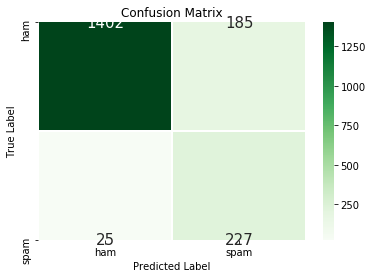

In [15]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest, y_pred)
class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True,cmap=plt.cm.Greens, fmt='d',annot_kws={'size':15}, linewidths=0.3)


plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [18]:
#5-fold validation
from sklearn.model_selection import cross_val_score
result = cross_val_score(clf, X_test_vect, ytest, cv=5)
result

array([0.88043478, 0.89402174, 0.88586957, 0.88043478, 0.89918256])

In [19]:
print('Average accuracy in sklearn NB classifier is:' , np.mean(result))

Average accuracy in sklearn NB classifier is: 0.8879886861746238


##### Conclusions:
1. In NB classifier (by hands version), as a result, it returns 5 accuracy score, and the average value is 0.898.
2. Compared with the accuacy value in sklearn NB classifier(0.888), the two results have no significant difference.
3. With sklearn Naive Bayes classifier, we can get the result easier as the algorithm has already been set up.
4. Plus, there are several Bayes models in sklearn, different models could bring different accuracy.